# <a id='Index'>Photoreceptor arrays</a>
- [Voronoi](#voronoi)
- [NDD](#ndd)
- [Batch analysis](#batch)
- [Distribution models???](#models)

Ideas:
- Use kNDD and bound it by theoretical hex lattice and random distributions (bootstrapped à la JohnBall)
- Use pairwise NDD within all subtypes? Are there exclusion zones between pairs?

To do:
- [x] visualisation for single example
    - [x] Voronoi
    - [x] Llloyd's algorithm + bounding box
    - [ ] Should rewrite Lloyd's implementation to use scipy.spatial functions (findCentroid) and to bound search withing box properly
    - [ ] random distribution (should I account for physical size of cones?)
    - [x] support for tiff loading
    - [x] single class that allows flexible inputs to run in any photoreceptor subtype (based on napari segmentation or points)
- [x] batch analysis
    - [x] NDD distribution for each image
    - [x] NDDi distribution after Lloyd's relaxation (and final point distribution)
    - [x] summary bot to collect medians and to create meta-distributions by genotype
- [ ] integrate into napari
    - [ ] calculate and display Voronoi: might be easiest to calculate and then transform to a labels layer: [codehere](https://napari.org/stable/gallery/shapes_to_labels.html)
    - [ ] run by default as a final step during curation of segmentation AND to help with dotting.
        - need to revise analysis of UV cones and where possible merge U_missing.csv and U_seg_curated.tiff into a single U_points.csv
    - [ ] Animation of Lloyd's algorithm could be fun. Could be set up as a z-stack initially

In [81]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.stats import sem
from scipy import stats as st 
import scikit_posthocs
import scipy.spatial
import math
import IPython
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import colorsys
import importlib
import svgutils
from svgutils.compose import *
import os.path
import time, sys, warnings
from tqdm.notebook import tqdm, trange
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from skimage.io import imread
import ipywidgets
from IPython.display import display
from plotParams import *
from lloyd import *


pBGMenu = ipywidgets.Dropdown(options=['Light', 'Dark'],value='Dark',disabled=False, layout=ipywidgets.Layout(width='20%', height='40px'))
pBGLabel = ipywidgets.widgets.Label('Select plotting style', layout=ipywidgets.Layout(width='20%', height='30px'))
pBG = ipywidgets.widgets.VBox([pBGLabel,pBGMenu])
pBG

In [2]:
baseColor = applyPlotStyle(pBGMenu.value)
# p2um = 63.64/1024


Plotting style is Dark


## Debugging code

In [ ]:
class NNDcalculator():
    '''
    Calculates NND (nearest-neighbour distances) and idealized NND (after running Lloyd's algorithm) using napari points or labels layer
    Created by Angueyra (Jan 2023)
    '''

    def __init__(self, dPath = '', celltype = 'U', datatype = 'points', nIter = 20, saveLloyd = False, overwriteFlag = False, **kwargs):
        '''
        descriptionHere
        '''
        self.dPath = dPath
        self.celltype = celltype
        self.datatype = datatype
        if (datatype=='labels'):
            self.fPath = self.celltype + '_seg_curated.tiff'
        elif (datatype=='points'):
            if (self.celltype=='U'):
                self.fPath = 'U_missing.csv'
            else:
                self.fPath = self.celltype + '_points.csv'
        self.ifPath = self.celltype + '_lloyd.npy'
        self.N_mip = 'N_mip.tiff'
        self.p2um = 63.64/1024
        self.kN = 1
        self.nIter = nIter
        self.Centroids = self.getCentroids();
        if (np.size(self.Centroids)>0): # skip any calculations if filepath is empty
            self.vor = scipy.spatial.Voronoi(self.Centroids)
            self.kdt = scipy.spatial.KDTree(self.Centroids)
            self.nnd = self.calcNND()
            self.iCentroids = self.calcLloyd(nIter = self.nIter, overwriteFlag = overwriteFlag)
            self.ivor = scipy.spatial.Voronoi(self.iCentroids)
            self.ikdt = scipy.spatial.KDTree(self.iCentroids)
            self.innd = self.calcNNDi()
            if saveLloyd:
                self.saveLloyd()
        
    def getCentroids(self):
        # return empty array if file does not exist
        if (os.path.isfile(self.dPath + self.fPath)==False):
            warnings.warn('{0} does not exist'.format(self.dPath + self.fPath))
            Centroids = [];
        else:
            if (self.datatype=='points'): # assumes input is structured like a napari points layer
                df =  pd.read_csv(self.dPath + self.fPath)
                df = df.drop(columns = 'index')
                Centroids = df.to_numpy()
                Centroids = Centroids[:,[1,0]]
            elif(self.datatype=='labels'): # input is an image file akin to napari labels layer
                labelData = imread (self.dPath + self.fPath)
                Centroids = calculateCentroidsFromLabels(labelData)
        return Centroids
        
    def calcNND(self):
        nnd = self.findNND(self.Centroids, self.kdt, self.kN)
        return nnd

    def calcNNDi(self):
        nndi = self.findNND(self.iCentroids, self.ikdt, self.kN)
        return nndi
    
    @staticmethod
    def findNND(centroids, kdt, kN):
        # initialize emtpy arrays
        nnd = np.empty((len(centroids),kN))
        nnd[:]=np.NaN
        # find k nearest neighbor distances
        for n in range(0,len(centroids)):
            temp = kdt.query(centroids[n],kN+1)
            for k in range (0,kN):
                nnd[n,k] = temp[0][k+1]
        return nnd

    
    def calcLloyd(self,nIter=20, overwriteFlag = False):
        if ((os.path.isfile(self.dPath + self.ifPath)) & (overwriteFlag == False)):
            print('Loaded saved Lloyd relaxation')
            iCentroids = np.load(self.dPath + self.ifPath, allow_pickle=True)
        else:
            #start from original locations
            field = Field(self.Centroids, buffer = 20) 
            # # #start from center of the field
            # rng = np.random.default_rng()
            # rndCentroids = rng.integers(500,525, size=np.shape(self.Centroids))
            # field = Field(rndCentroids, buffer = 20) 
            with tqdm(total=nIter, file=sys.stdout) as progBar:
            # run Lloyd relaxation on the field of points
                for i in np.arange(0,nIter):
                    field.relax()
                    progBar.update(1)
            # get the resulting point positions
            iCentroids = field.get_points()
        return iCentroids
    
    def saveLloyd(self):
        np.save(self.dPath + self.ifPath, self.iCentroids)
        np.save(self.dPath + 'nnd.npy', self.nnd)
        np.save(self.dPath + 'innd.npy', self.innd)
        print('Saved results for {0}'.format(self.dPath))
    
    def plotAll(self):
        fH, axH = plt.subplots(2, 2, figsize= [24,24], gridspec_kw={'height_ratios': [5, 1]})
        axH[0,1].sharey(axH[0,0])
        axH[1,1].sharey(axH[1,0])
        self.plotVor(fH, axH[0,0]);
        self.plotLloyd(fH, axH[0,1]);
        self.plotNDD(fH,axH[1,0]);
        self.plotNDDLloyd(fH,axH[1,1]);
        fH.tight_layout()
        return fH, axH
        
    def plotVor(self, fH, axH, plotRegions = False):
        '''
        plotter for N_mip, U locations and voronoi partition
        '''

        pH = axH.imshow(imread(self.dPath + self.N_mip), cmap='bone')
        
        pH = axH.scatter(self.Centroids[:,0],self.Centroids[:,1], color=zfC[self.celltype], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = 0.99);
        pH = scipy.spatial.voronoi_plot_2d(self.vor, ax = axH, show_points = False, show_vertices=False, line_colors=zfC[self.celltype], line_width=2, line_alpha=0.99, point_size=2)
        
        if plotRegions:
            regions, vertices = voronoi_finite_polygons_2d(self.vor)
            # colorize
            for region in regions:
                polygon = vertices[region]
                axH.fill(*zip(*polygon), alpha=0.2)
        
        fontLabels = formatFigureMain(fH, axH, pH);
        axH.set_xlabel('d ($\mu$m)', fontproperties=fontLabels)
        axH.set_ylabel('d ($\mu$m)', fontproperties=fontLabels)
        axH.set_xlim([-100,1124])
        axH.set_ylim([-100,1124])
        
        def p2umfx(x, pos): # formatter function to convert pixels to microns
            s = '{:.2f}'.format(np.round(x * self.p2um,decimals=2))
            return s

        axH.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(p2umfx))
        axH.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(p2umfx))
        return fH, axH
    
    def plotLloyd(self, fH, axH):
        '''
        plotter for N_mip, U locations and voronoi partition after Lloyd's relaxation
        '''

        pH = axH.imshow(imread(self.dPath + self.N_mip), cmap='bone')
        
        pH = axH.scatter(self.Centroids[:,0],self.Centroids[:,1], color=zfC[self.celltype], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .2);
        pH = scipy.spatial.voronoi_plot_2d(self.vor, ax = axH, show_points = False, show_vertices=False, line_colors=zfC[self.celltype], line_width=2, line_alpha=0.2, point_size=2)
        
        pH = axH.scatter(self.iCentroids[:,0],self.iCentroids[:,1], color='#FFFFFF', zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .99);
        pH = scipy.spatial.voronoi_plot_2d(self.ivor, ax = axH, show_points = False, show_vertices=False, line_colors='#FFFFFF', line_width=2, line_alpha=0.99, point_size=2)
        
        # regions, vertices = voronoi_finite_polygons_2d(self.vor)
        # # colorize
        # for region in regions:
        #     polygon = vertices[region]
        #     plt.fill(*zip(*polygon), alpha=0.2)
        
        fontLabels = formatFigureMain(fH, axH, pH);
        axH.set_xlabel('d ($\mu$m)', fontproperties=fontLabels)
        axH.set_ylabel('d ($\mu$m)', fontproperties=fontLabels)
        axH.set_xlim([-100,1124])
        axH.set_ylim([-100,1124])
        
        def p2umfx(x, pos): # formatter function to convert pixels to microns
            s = '{:.2f}'.format(np.round(x * self.p2um,decimals=2))
            return s

        axH.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(p2umfx))
        axH.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(p2umfx))
        return fH, axH
    
    def plotNDD(self, fH, axH):
        '''
        plotter for NDD distribution
        '''
        for k in range (0,self.kN):
            pH = axH.hist(self.nnd[:,k]*self.p2um, bins=20, color=zfC[self.celltype], edgecolor=baseColor, linewidth=0.5, alpha = .8, histtype='stepfilled');
            
        axH.set_xlim([0,np.max((self.nnd*self.p2um)*1.2)])
        fontLabels = formatFigureMain(fH, axH, pH);
        axH.set_xlabel('nnd ($\mu$m)', fontproperties=fontLabels)
        axH.set_ylabel('counts', fontproperties=fontLabels)
        
        nndmedian = np.median(self.nnd[:,k])
        pH = axH.axvline(nndmedian*self.p2um, color = lighten_color(zfC[self.celltype],0.5), linestyle='--')
        
        # summarize using median
        print ('\n number of UV cones = {0}'.format(len(self.Centroids)))
        for k in range (0,self.kN):
            print ('Median for {0}-NDD (Raw):\t {1:.2f} pixels\t {2:.2f} um'.format(k+1,nndmedian,nndmedian*self.p2um))
            # print ('Median for {0}-NDD UV-cones (Lloyd):\t {1:.2f} pixels\t {2:.2f} um'.format(k+1,inndmedian,inndmedian*self.p2um))
    
    def plotNDDLloyd(self, fH, axH):
        '''
        plotter for NDD distribution after Lloyd's relaxation
        '''
        for k in range (0,self.kN):
            pH = axH.hist(self.nnd[:,k]*self.p2um, bins=20, color=zfC[self.celltype], edgecolor=baseColor, linewidth=0.5, alpha = .8, histtype='stepfilled');
            
            pH = axH.hist(self.innd[:,k]*self.p2um, bins=20, color='#FFFFFF', edgecolor=baseColor, linewidth=0.5, alpha = .8, histtype='stepfilled');
            
        axH.set_xlim([0,np.max((self.nnd*self.p2um)*1.2)])
        fontLabels = formatFigureMain(fH, axH, pH);
        axH.set_xlabel('nnd ($\mu$m)', fontproperties=fontLabels)
        axH.set_ylabel('counts', fontproperties=fontLabels)
        
        nndmedian = np.median(self.nnd[:,k])
        pH = axH.axvline(nndmedian*self.p2um, color = lighten_color(zfC[self.celltype],0.5), linestyle='--')

        
        inndmedian = np.median(self.innd[:,k])
        pH = axH.axvline(inndmedian*self.p2um, color = lighten_color('#ffffff',0.5), linestyle=':')
        
        # summarize using median
        for k in range (0,self.kN):
            print ('Median for {0}-NDD (Lloyd):\t {1:.2f} pixels\t {2:.2f} um'.format(k+1,inndmedian,inndmedian*self.p2um))

## <a id='batch'>Batch analysis</a>
- Starting with a one liner that calculates everything
- Will make into a for loop
- Will need an interator that compiles data across images


> [Back to index](#Index)

In [37]:
# get folder names
# dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/m2Gs2C/nr2e3/'
dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/'
fList = !ls $dPath
fList = list(map(lambda st: '\'' + st + '/\',', fList))
# fList = list(map(lambda st: 'fPath = \'' + st + '/\'', fList))
print(*fList, sep = "\n")

'20201113_5dpf_xOG_s1mCh_CRtbx2b_i09b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i14b/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L03_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L03_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/',


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L03_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L03_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L09_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L09_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L10_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L10_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L10_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L10_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L11_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L11_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L11_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L11_004/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L12_002/


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved results for /Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/20221026_5dpf_xOG_s1C_tbx2bF0_L12_002/

 number of UV cones = 39
Median for 1-NDD (Raw):	 110.59 pixels	 6.87 um
Median for 1-NDD (Lloyd):	 151.12 pixels	 9.39 um


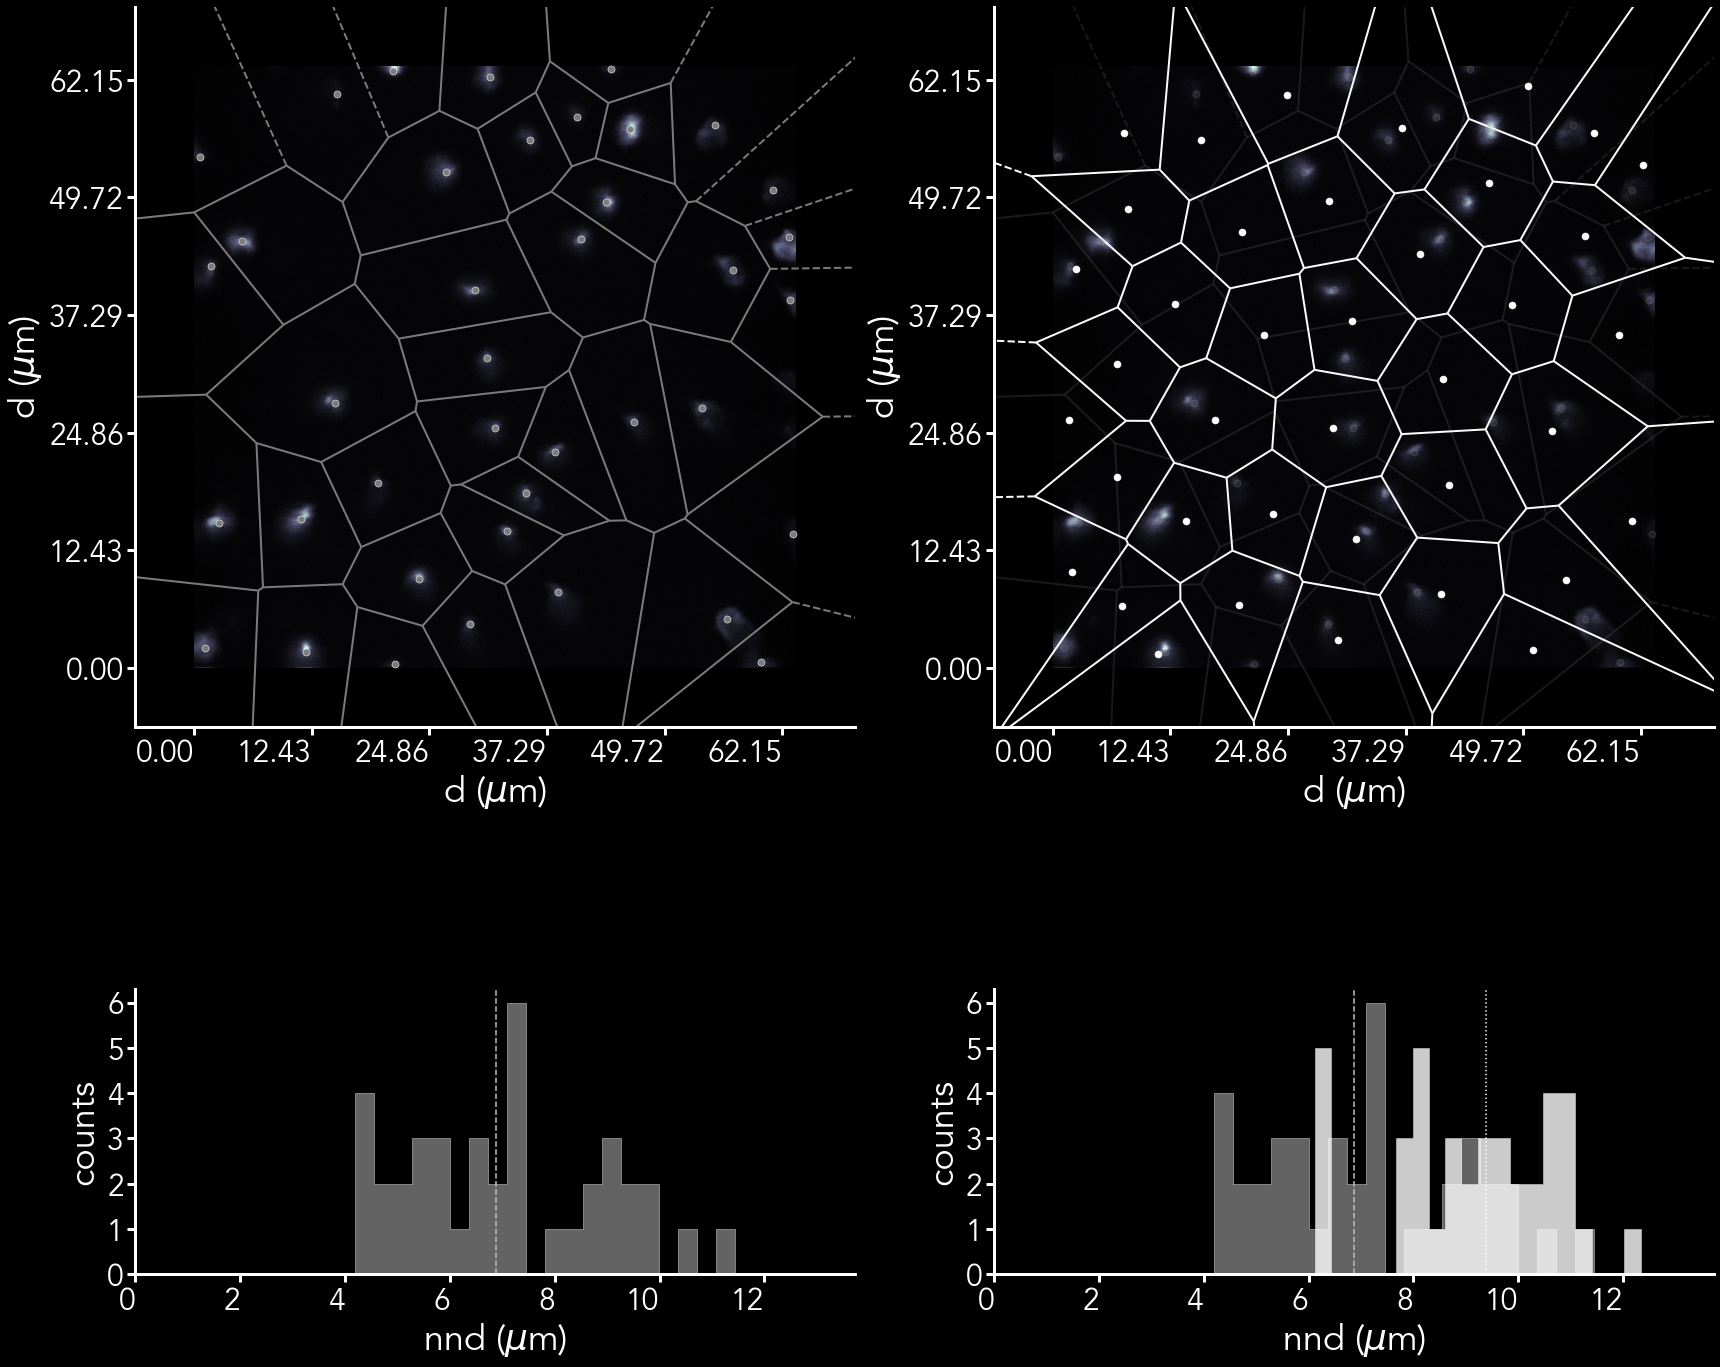

In [48]:
# dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/wt/'
# fPath = [
# '20200821_5dpf_xOG_s1mCh_uninj_i05b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i05d/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06b.nd2/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06d/',
# '20200821_5dpf_xOG_s1mCh_uninj_i101b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i101d/',
# '20200821_5dpf_xOG_s1mCh_uninj_i102b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i103b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i104b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i104d/',
# '20201113_5dpf_xOG_s1mCh_uninj_i06b/',
# '20201113_5dpf_xOG_s1mCh_uninjected_i12b/',
# '20201113_5dpf_xOG_s1mCh_uninjected_i12d/',
# '20201113_5dpf_xOG_s1mCh_uninjected_i13b/',
# '20201113_5dpf_xOG_s1mCh_uninjected_i15b/',
# '20201113_5dpf_xOG_s1mCh_uninjected_i15d/',
# '20210514_5dpf_xOG_s1C_uninj_L01b_withDAPI/',
# '20210514_5dpf_xOG_s1C_uninj_L05b_withDAPI/',
# '20210514_5dpf_xOG_s1C_uninj_L07b_withDAPI/',
# '20221026_5dpf_xOG_s1C_wt_L01_002/',
# '20221026_5dpf_xOG_s1C_wt_L01_004/',
# '20221026_5dpf_xOG_s1C_wt_L02_002/',
# '20221026_5dpf_xOG_s1C_wt_L03_002/',
# '20221026_5dpf_xOG_s1C_wt_L03_004/',
# '20221026_5dpf_xOG_s1C_wt_L04_002/',
# '20221026_5dpf_xOG_s1C_wt_L04_004/',
# '20221026_5dpf_xOG_s1C_wt_L05_002/',
# '20221026_5dpf_xOG_s1C_wt_L05_004/',
# '20221026_5dpf_xOG_s1C_wt_L06_002/',
# '20221026_5dpf_xOG_s1C_wt_L07_002/',
# '20221026_5dpf_xOG_s1C_wt_L07_004/',
# '20221026_5dpf_xOG_s1C_wt_L08_002/',
# '20221026_5dpf_xOG_s1C_wt_L08_004/',
# '20221026_5dpf_xOG_s1C_wt_L09_002/',
# '20221026_5dpf_xOG_s1C_wt_L09_004/',
# '20221026_5dpf_xOG_s1C_wt_L10_002/',
# '20221026_5dpf_xOG_s1C_wt_L10_004/',
# '20221026_5dpf_xOG_s1C_wt_L11_002/',
# '20221026_5dpf_xOG_s1C_wt_L12_002/',
# ]

# for filepath in fPath:
#     nnd = NNDcalculator(dPath = dPath + filepath, celltype = 'U', datatype = 'labels', bg = 'U_mip', nIter = 1000, saveLloyd = True, overwriteFlag = False)
#     nnd = NNDcalculator(dPath = dPath + filepath, celltype = 'R', datatype = 'labels', bg = 'R_mip', nIter = 1000, saveLloyd = True, overwriteFlag = False)

# nnd.plotAll()
    
# dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2a/'
# fPath = [
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i05b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i05d/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i06b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i06d/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i07b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i07d/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i08b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i08d/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i09b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i09d/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i10b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i10d/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i11b/',
# '20200821_5dpf_xOG_s1mCh_CRtbx2a_i11d/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L01b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L02b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L03b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L04b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L05b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L06b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L07b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L07d/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L08b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L08d/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L09b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L10b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L11b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L11d/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L12b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L13b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L13d/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L14b/',
# '20210514_5dpf_xOG_s1C_CRtbx2a_L15b/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L01_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L01_004/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L02_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L02_004/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L03_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L05_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L05_004/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L06_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L06_004/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L07_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L07_004/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L08_002/',
# '20221026_5dpf_xOG_s1C_tbx2aF0_L08_004/',
# ]

# for filepath in fPath:
#     nnd = NNDcalculator(dPath = dPath + filepath, celltype = 'U', datatype = 'labels', bg = 'U_mip', nIter = 1000, saveLloyd = True, overwriteFlag = False)
#     nnd = NNDcalculator(dPath = dPath + filepath, celltype = 'R', datatype = 'labels', bg = 'R_mip', nIter = 1000, saveLloyd = True, overwriteFlag = False)
    

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/'
fPath = [
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i09b/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i10b/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i10d/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i12b/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i12d/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i13b/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i13d/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i14b/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L03_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L03_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L12_002/',
]

for filepath in fPath:
    nnd = NNDcalculator(dPath = dPath + filepath, celltype = 'U', datatype = 'labels', bg = 'U_mip', nIter = 1000, saveLloyd = True, overwriteFlag = False)
    nnd = NNDcalculator(dPath = dPath + filepath, celltype = 'R', datatype = 'labels', bg = 'R_mip', nIter = 1000, saveLloyd = True, overwriteFlag = False)

    

nnd.plotAll();


In [ ]:
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/wt/'
fPath = [
    # '20220121_5dpf_xOG_aCT_wt_L01_002/',
    # '20220121_5dpf_xOG_aCT_wt_L02_002/',
    # '20220121_5dpf_xOG_aCT_wt_L02_004/',
    # '20220121_5dpf_xOG_aCT_wt_L03_002/',
    # '20220121_5dpf_xOG_aCT_wt_L03_004/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_wt_L04_002/',
    # '20220121_5dpf_xOG_aCT_wt_L05_002/',
    # '20220121_5dpf_xOG_aCT_wt_L06_002/',
    # '20220121_5dpf_xOG_aCT_wt_L07_002/',
    # '20220121_5dpf_xOG_aCT_wt_L07_004/',
    # '20220121_5dpf_xOG_aCT_wt_L08_002/',
    # '20220121_5dpf_xOG_aCT_wt_L08_004/',
    # '20220121_5dpf_xOG_aCT_wt_L09_002/',
    # '20220121_5dpf_xOG_aCT_wt_L09_004/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_wt_L10_002/',
    # '20220121_5dpf_xOG_aCT_wt_L10_004/',
    # '20220121_5dpf_xOG_aCT_wt_L11_002/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_wt_L11_004/',
    # '20220121_5dpf_xOG_aCT_wt_L12_002/',
    # '20220121_5dpf_xOG_aCT_wt_L13_002/',
    # '20220121_5dpf_xOG_aCT_wt_L13_004/',
    # '20220121_5dpf_xOG_aCT_wt_L14_002/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_wt_L15_002/',
    # '20220121_5dpf_xOG_aCT_wt_L16_002/',
]

for filepath in fPath:
    ndd = NNDcalculator(dPath = dPath + filepath, nIter = 1000, saveLloyd = True, overwriteFlag = False)

In [ ]:
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/nr2f1b/'
fPath = [
    '20220121_5dpf_xOG_aCT_nr2f1b_L01_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L01_004/',
    # '20220121_5dpf_xOG_aCT_nr2f1b_L02_002/', # no UV cones dotted
    '20220121_5dpf_xOG_aCT_nr2f1b_L02_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L03_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L03_004/',
    # '20220121_5dpf_xOG_aCT_nr2f1b_L04_002/', # no UV cones dotted
    '20220121_5dpf_xOG_aCT_nr2f1b_L04_004/',
    # '20220121_5dpf_xOG_aCT_nr2f1b_L05_002/', # no UV cones dotted
    '20220121_5dpf_xOG_aCT_nr2f1b_L05_004/',
    # '20220121_5dpf_xOG_aCT_nr2f1b_L06_002/', # no UV cones dotted
    '20220121_5dpf_xOG_aCT_nr2f1b_L07_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L08_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L08_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L09_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L09_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L10_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L10_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L11_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L11_004/',
    # '20220121_5dpf_xOG_aCT_nr2f1b_L12_002/', # no UV cones dotted
]

for filepath in fPath:
    ndd = NNDcalculator(dPath = dPath + filepath, nIter = 1000, saveLloyd = True, overwriteFlag = False)

In [ ]:
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/nr2e3/'
fPath = [
    # '20220121_5dpf_xOG_aCT_nr2e3_L01_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L01_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L02_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L02_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L03_002/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_nr2e3_L03_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L05_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L06_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L06_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L07_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L07_004/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_nr2e3_L08_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L08_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L09_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L09_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L10_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L10_004/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L11_002/', # empty UV cones file
    # '20220121_5dpf_xOG_aCT_nr2e3_L12_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L12_004/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_nr2e3_L14_002/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_nr2e3_L15_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L15_004/', # no UV cones dotted
    # '20220121_5dpf_xOG_aCT_nr2e3_L16_002/',
    # '20220121_5dpf_xOG_aCT_nr2e3_L16_004/', # something weird happened with Voronoi
]

for filepath in fPath:
    ndd = NNDcalculator(dPath = dPath + filepath, nIter = 1000, saveLloyd = True, overwriteFlag = False)

## Plot individual retinas

In [84]:
!jupyter labextension list

JupyterLab v3.2.1
/Users/angueyraaristjm/opt/anaconda3/share/jupyter/labextensions
        jupyterlab-jupytext v1.3.8+dev enabled OK (python, jupytext)
        @jupyter-widgets/jupyterlab-manager v3.0.0 enabled OK (python, jupyterlab_widgets)



In [171]:
dPath = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2a/"
fList = sorted([f for f in os.listdir(dPath) if not f.startswith('.')])

fLabel = ipywidgets.widgets.Label('Select filepath', layout=ipywidgets.Layout(width='10%', height='40px'))
fMenu = ipywidgets.Dropdown(options=fList,value=fList[0],disabled=False,layout=ipywidgets.Layout(width='30%', height='40px'))
fButton = ipywidgets.Button(description='plotNDD',disabled=False,button_style='',tooltip='plotNDD',
                            icon='check',layout=ipywidgets.Layout(width='20%', height='40px'))
fOut = ipywidgets.Output(layout=ipywidgets.Layout(width='40%', height='40px'))
def on_button_clicked(b):
    with fOut:
        fOut.clear_output()
        fPath = fMenu.value
        print(fPath)
fButton.on_click(on_button_clicked)
fSelect = ipywidgets.widgets.HBox([fLabel,fMenu,fButton,fOut])
fSelect

Loaded saved Lloyd relaxation

 number of UV cones = 145
Median for 1-NDD (Raw):	 65.11 pixels	 4.05 um
Median for 1-NDD (Lloyd):	 81.93 pixels	 5.09 um


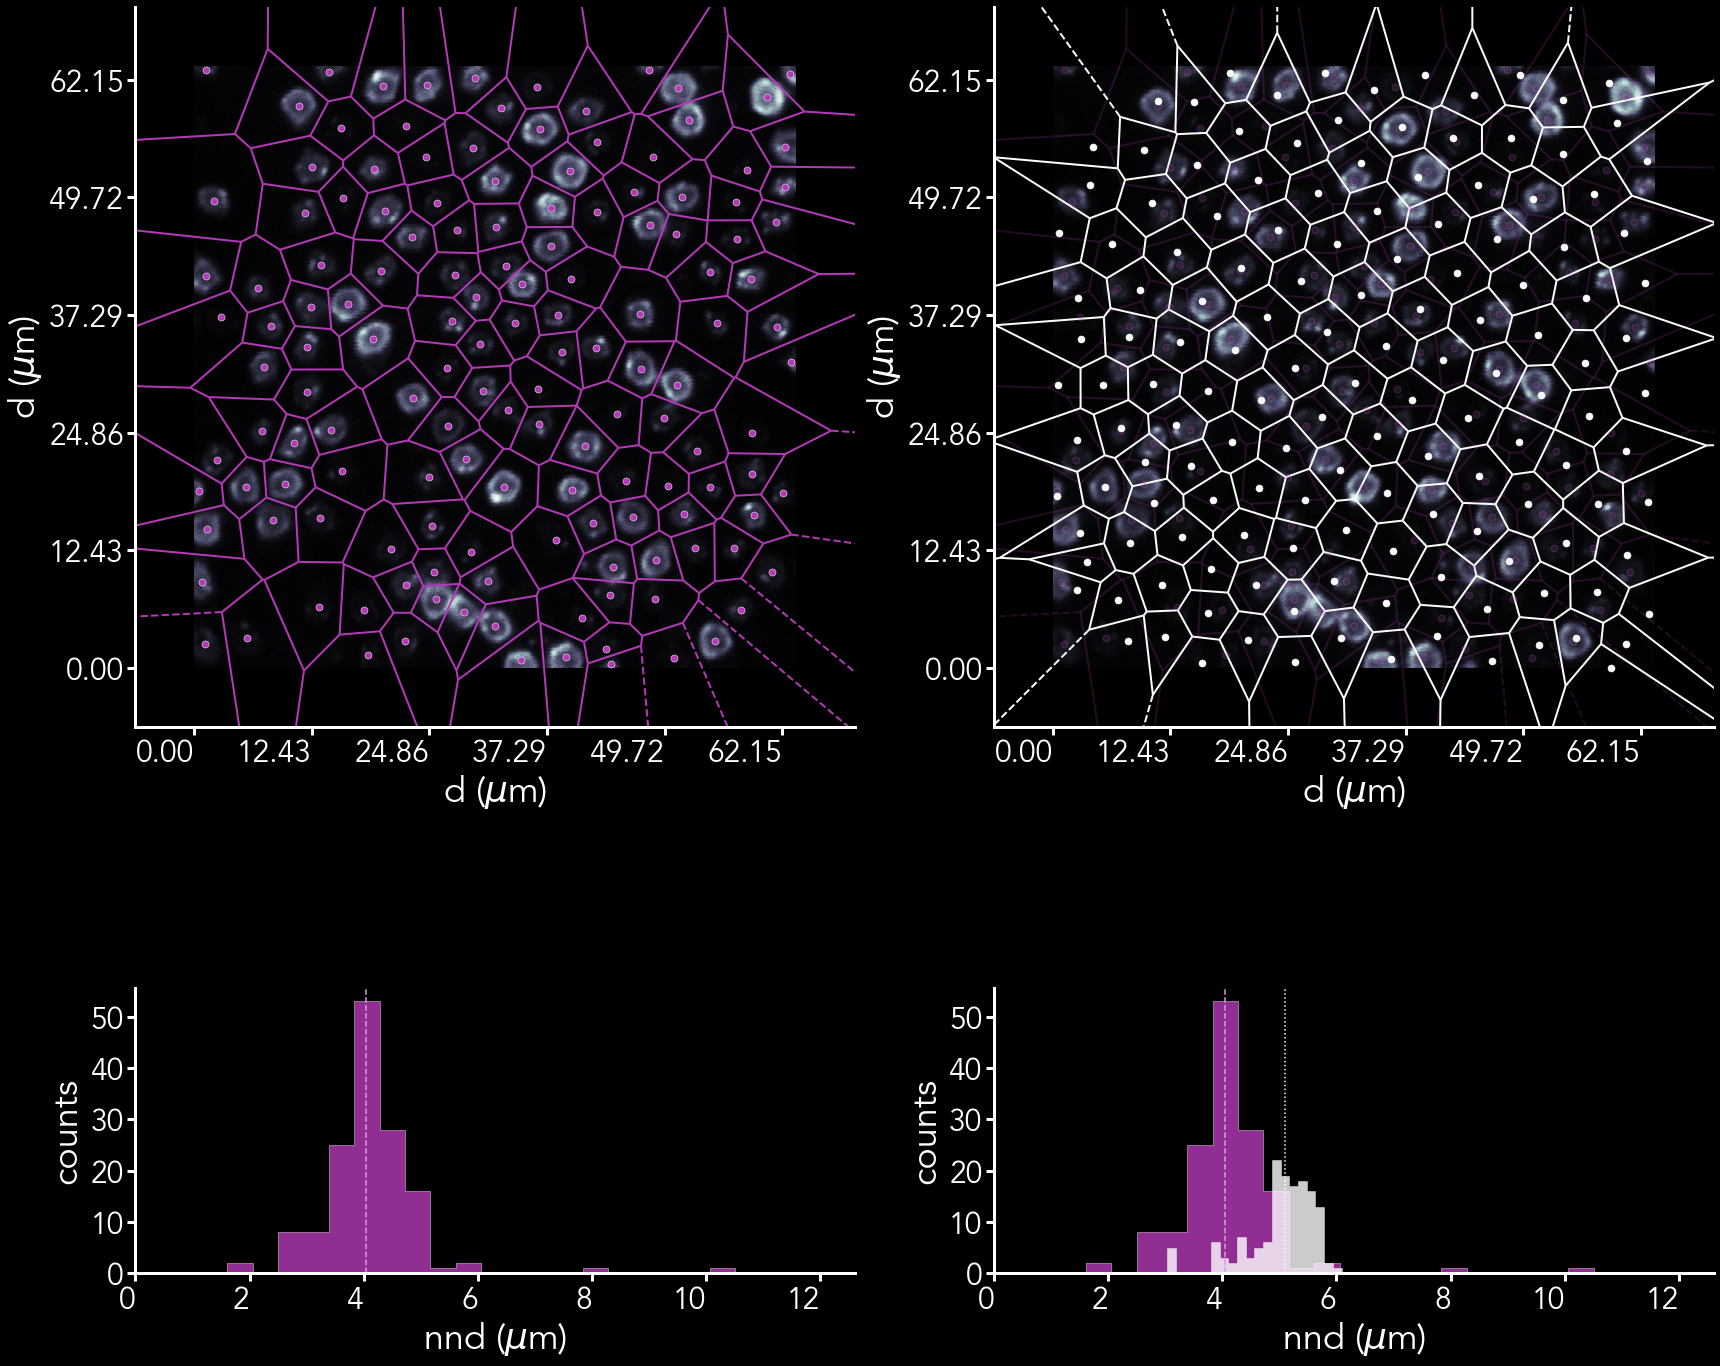

In [217]:
fPath = fMenu.value + '/'
ndd = NNDcalculator(dPath = dPath + fPath, celltype = 'U', datatype = 'labels', bg = 'U_mip')
ndd.plotAll();

In [ ]:

# dAnalysis = "/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/"
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/wt/'
fPath = '20220121_5dpf_xOG_aCT_wt_L01_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L02_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L02_004/'
fPath = '20220121_5dpf_xOG_aCT_wt_L03_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L04_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L05_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L06_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L07_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L07_004/'
fPath = '20220121_5dpf_xOG_aCT_wt_L08_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L08_004/'
fPath = '20220121_5dpf_xOG_aCT_wt_L09_002/'
fPath = '20220121_5dpf_xOG_aCT_wt_L10_002/'
#### fPath = '20220121_5dpf_xOG_aCT_wt_L10_004/' # incomplete dotting
fPath = '20220121_5dpf_xOG_aCT_wt_L11_004/'
fPath = '20220121_5dpf_xOG_aCT_wt_L12_002/'
#### fPath = '20220121_5dpf_xOG_aCT_wt_L13_002/' # incomplete dotting
fPath = '20220121_5dpf_xOG_aCT_wt_L13_004/'
#### fPath = '20220121_5dpf_xOG_aCT_wt_L15_002/' # incomplete dotting
#### fPath = '20220121_5dpf_xOG_aCT_wt_L16_002/' # incomplete dotting

ndd = NNDcalculator(dPath = dPath + fPath)
ndd.plotAll();


In [ ]:
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/nr2e3/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L01_002/' # there's one UV cone not dotted that skews things
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L01_004/'
#### fPath = '20220121_5dpf_xOG_aCT_nr2e3_L02_002/' # incomplete dotting
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L02_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L03_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L05_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L06_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L06_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L07_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L08_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L08_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L09_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L09_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L10_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L10_004/' # there's one UV cone not dotted that skews things
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L12_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L15_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2e3_L16_002/'

dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/nr2f1b/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L01_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L01_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L02_004/' # 2 UV cone missing clearly disrupt pattern
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L03_002/'
#### fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L03_004/' # incomplete dotting
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L04_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L05_004/' # 1 UV cone missing
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L07_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L08_002/' # some missing in corner
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L08_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L09_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L09_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L10_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L10_004/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L11_002/'
fPath = '20220121_5dpf_xOG_aCT_nr2f1b_L11_004/'

ndd2 = NNDcalculator(dPath = dPath + fPath)
ndd2.plotAll();


## Collect NDD distributions across cells

### F&empty;[_nr2e3_]

In [ ]:
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/wt/'
fPath = [
    '20220121_5dpf_xOG_aCT_wt_L01_002/',
    '20220121_5dpf_xOG_aCT_wt_L02_002/',
    '20220121_5dpf_xOG_aCT_wt_L02_004/',
    '20220121_5dpf_xOG_aCT_wt_L03_002/',
    '20220121_5dpf_xOG_aCT_wt_L04_002/',
    '20220121_5dpf_xOG_aCT_wt_L05_002/',
    '20220121_5dpf_xOG_aCT_wt_L06_002/',
    '20220121_5dpf_xOG_aCT_wt_L07_002/',
    '20220121_5dpf_xOG_aCT_wt_L07_004/',
    '20220121_5dpf_xOG_aCT_wt_L08_002/',
    '20220121_5dpf_xOG_aCT_wt_L08_004/',
    '20220121_5dpf_xOG_aCT_wt_L09_002/',
    '20220121_5dpf_xOG_aCT_wt_L10_002/',
    '20220121_5dpf_xOG_aCT_wt_L11_004/',
    '20220121_5dpf_xOG_aCT_wt_L12_002/',
    '20220121_5dpf_xOG_aCT_wt_L13_004/',
]
nndUMean_wt = np.empty((len(fPath),1))
nndUMean_wt[:]=np.NaN
i=0;
for filepath in fPath:
    # ndd = NNDcalculator(dPath = dPath + filepath)
    nnd = np.load(dPath + filepath + 'nndU.npy')
    nndUMean_wt[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;

dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/nr2e3/'
fPath = [
    '20220121_5dpf_xOG_aCT_nr2e3_L01_002/', # there's one UV cone not dotted that skews things
    '20220121_5dpf_xOG_aCT_nr2e3_L01_004/',
    '20220121_5dpf_xOG_aCT_nr2e3_L02_004/',
    '20220121_5dpf_xOG_aCT_nr2e3_L03_004/',
    '20220121_5dpf_xOG_aCT_nr2e3_L05_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L06_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L06_004/',
    '20220121_5dpf_xOG_aCT_nr2e3_L07_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L08_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L08_004/',
    '20220121_5dpf_xOG_aCT_nr2e3_L09_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L09_004/',
    '20220121_5dpf_xOG_aCT_nr2e3_L10_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L10_004/', # there's one UV cone not dotted that skews things
    '20220121_5dpf_xOG_aCT_nr2e3_L12_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L15_002/',
    '20220121_5dpf_xOG_aCT_nr2e3_L16_002/',
]

nndUMean_nr2e3 = np.empty((len(fPath),1))
nndUMean_nr2e3[:]=np.NaN
i=0;
for filepath in fPath:
    # ndd = NNDcalculator(dPath = dPath + filepath)
    nnd = np.load(dPath + filepath + 'nndU.npy')
    nndUMean_nr2e3[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;
    
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/nr2f1b/'
fPath = [
    '20220121_5dpf_xOG_aCT_nr2f1b_L01_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L01_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L02_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L03_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L04_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L05_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L07_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L08_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L08_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L09_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L09_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L10_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L10_004/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L11_002/',
    '20220121_5dpf_xOG_aCT_nr2f1b_L11_004/',
]
nndUMean_nr2f1b = np.empty((len(fPath),1))
nndUMean_nr2f1b[:]=np.NaN
i=0;
for filepath in fPath:
    # ndd = NNDcalculator(dPath = dPath + filepath)
    nnd = np.load(dPath + filepath + 'nndU.npy')
    nndUMean_nr2f1b[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;

In [ ]:
plotname = ''
fH, axH = plt.subplots(figsize= [9,12])

i = 0
for nndM,geneColor,geneMarker in zip([nndUMean_wt,nndUMean_nr2e3,nndUMean_nr2f1b],['#888888','#BF141B','#8888BB'],['o','o','o']):
    i = i+1
    jitter = np.random.randn(len(nndM))*0.05
    pH = plt.bar(i, np.mean(nndM), width=0.5, color=geneColor, linewidth = 2, edgecolor = geneColor);
    pH = plt.errorbar(i, np.mean(nndM), yerr = [[0],[np.std(nndM)]], ecolor=geneColor, elinewidth=3, capsize=8, capthick=3, zorder=9)
    pH = plt.scatter(np.ones(len(nndM))*i+jitter, nndM,
             color=lighten_color(geneColor,.75), zorder=8, marker = geneMarker, s=100, edgecolor=baseColor, linewidth=1, alpha = 0.6);

fontLabels = formatFigureMain(fH, axH, pH)
axH.set_xticks([1,2,3]);
axH.set_xticklabels(['wt','F0[nr2e3]','F0[nr2f1b]']);
axH.xaxis.set_tick_params(rotation=45)
# axH.set_ylim([0,300]); # tbx2
axH.set_ylabel('median UVndd  (um)', fontproperties=fontLabels)
plt.show()

### F&empty;[_foxq2_]

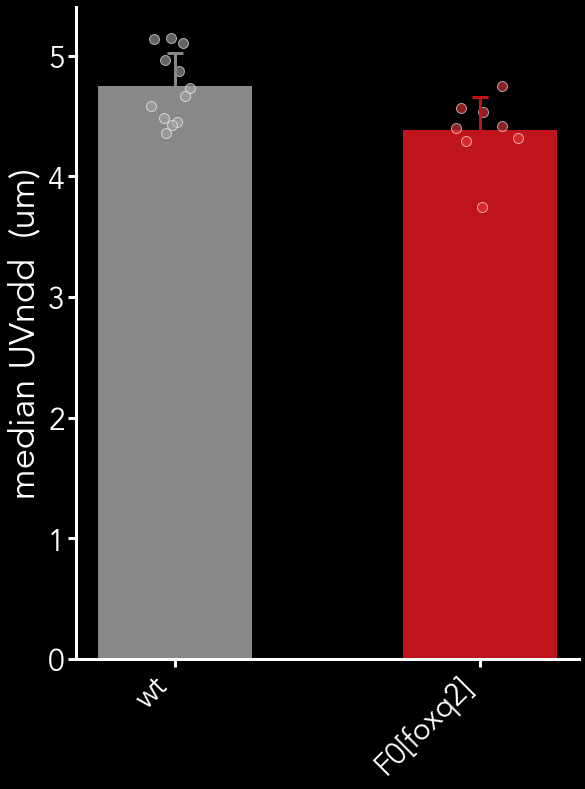

In [8]:
celltype = 'U'

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRfoxq2F0/xOGs1C/wt/'
fPath = [
    '20210514_5dpf_xOG_s1C_uninj_L01b/',
    '20210514_5dpf_xOG_s1C_uninj_L02b/',
    '20210514_5dpf_xOG_s1C_uninj_L03b/',
    '20210514_5dpf_xOG_s1C_uninj_L04b/',
    '20210514_5dpf_xOG_s1C_uninj_L05b_withDAPI/',
    '20210514_5dpf_xOG_s1C_uninj_L05d/',
    '20210514_5dpf_xOG_s1C_uninj_L06b/',
    '20210514_5dpf_xOG_s1C_uninj_L07b_withDAPI/',
    '20210514_5dpf_xOG_s1C_uninj_L09b/',
    '20210514_5dpf_xOG_s1C_uninj_L10b/',
    '20210514_5dpf_xOG_s1C_uninj_L11b/',
    '20210514_5dpf_xOG_s1C_uninj_L12b/',
]


nndUMean_wt = np.empty((len(fPath),1))
nndUMean_wt[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_wt[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRfoxq2F0/xOGs1C/foxq2/'
fPath = [
    '20210514_5dpf_xOG_s1C_CRfoxq2_L01b/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L01d/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L02b/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L03b/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L04b/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L06b/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L07b/',
    '20210514_5dpf_xOG_s1C_CRfoxq2_L08b/',
]

nndUMean_foxq2 = np.empty((len(fPath),1))
nndUMean_foxq2[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_foxq2[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;
    
plotname = ''
fH, axH = plt.subplots(figsize= [9,12])

i = 0
for nndM,geneColor,geneMarker in zip([nndUMean_wt,nndUMean_foxq2],['#888888','#BF141B'],['o','o']):
    i = i+1
    jitter = np.random.randn(len(nndM))*0.05
    pH = plt.bar(i, np.mean(nndM), width=0.5, color=geneColor, linewidth = 2, edgecolor = geneColor);
    pH = plt.errorbar(i, np.mean(nndM), yerr = [[0],[np.std(nndM)]], ecolor=geneColor, elinewidth=3, capsize=8, capthick=3, zorder=9)
    pH = plt.scatter(np.ones(len(nndM))*i+jitter, nndM,
             color=lighten_color(geneColor,.75), zorder=8, marker = geneMarker, s=100, edgecolor=baseColor, linewidth=1, alpha = 0.6);

fontLabels = formatFigureMain(fH, axH, pH)
axH.set_xticks([1,2]);
axH.set_xticklabels(['wt','F0[foxq2]']);
axH.xaxis.set_tick_params(rotation=45)
# axH.set_ylim([0,300]); # tbx2
axH.set_ylabel('median UVndd  (um)', fontproperties=fontLabels)
plt.show()

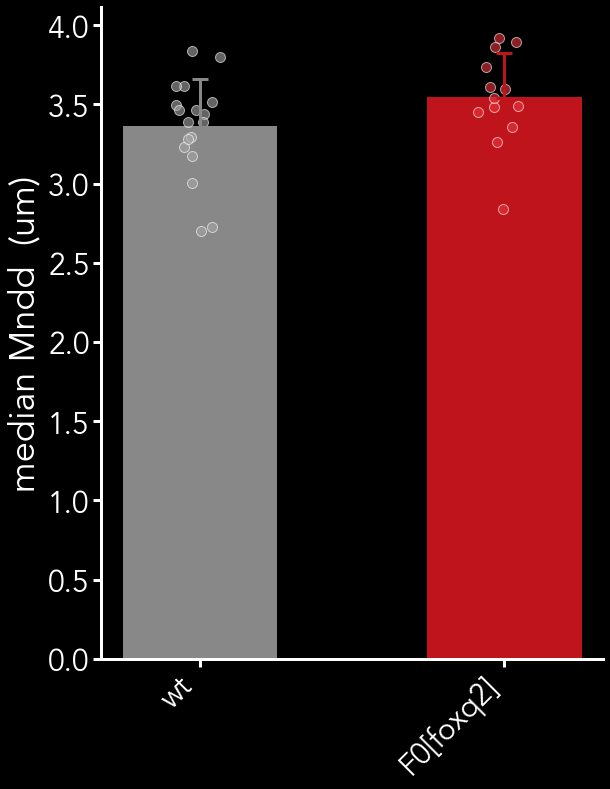

In [30]:





celltype = 'M'

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRfoxq2F0/mw2Gt2T/wt/'
fPath = [
'20210716_5dpf_m2G_t2T_uninj_L101b/',
'20210716_5dpf_m2G_t2T_uninj_L101d/',
'20210716_5dpf_m2G_t2T_uninj_L102b/',
'20210716_5dpf_m2G_t2T_uninj_L103b/',
'20210716_5dpf_m2G_t2T_uninj_L103d/',
'20210716_5dpf_m2G_t2T_uninj_L104b/',
'20210716_5dpf_m2G_t2T_uninj_L104d/',
'20210716_5dpf_m2G_t2T_uninj_L105b/',
'20210716_5dpf_m2G_t2T_uninj_L106b/',
'20210716_5dpf_m2G_t2T_uninj_L106d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L01b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L03b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L03d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L05b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L05d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L12b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L12d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_uninj_L14b/',
]


nndUMean_wt = np.empty((len(fPath),1))
nndUMean_wt[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_wt[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRfoxq2F0/mw2Gt2T/foxq2/'
fPath = [
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L01b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L01d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L02b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L02d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L03b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L03d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L04b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L05b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L05d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L06b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L06d/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L07b/',
'20210716_5dpf_t2T_m2G_mZpr1405_rbSopCy5_CRfoxq2_L07d/',
]


nndUMean_foxq2 = np.empty((len(fPath),1))
nndUMean_foxq2[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_foxq2[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;
    
plotname = ''
fH, axH = plt.subplots(figsize= [9,12])

i = 0
for nndM,geneColor,geneMarker in zip([nndUMean_wt,nndUMean_foxq2],['#888888','#BF141B'],['o','o']):
    i = i+1
    jitter = np.random.randn(len(nndM))*0.05
    pH = plt.bar(i, np.mean(nndM), width=0.5, color=geneColor, linewidth = 2, edgecolor = geneColor);
    pH = plt.errorbar(i, np.mean(nndM), yerr = [[0],[np.std(nndM)]], ecolor=geneColor, elinewidth=3, capsize=8, capthick=3, zorder=9)
    pH = plt.scatter(np.ones(len(nndM))*i+jitter, nndM,
             color=lighten_color(geneColor,.75), zorder=8, marker = geneMarker, s=100, edgecolor=baseColor, linewidth=1, alpha = 0.6);

fontLabels = formatFigureMain(fH, axH, pH)
axH.set_xticks([1,2]);
axH.set_xticklabels(['wt','F0[foxq2]']);
axH.xaxis.set_tick_params(rotation=45)
# axH.set_ylim([0,300]); # tbx2
axH.set_ylabel('median {0}ndd  (um)'.format(celltype), fontproperties=fontLabels)
plt.show()

### F&empty;[_tbx2_]

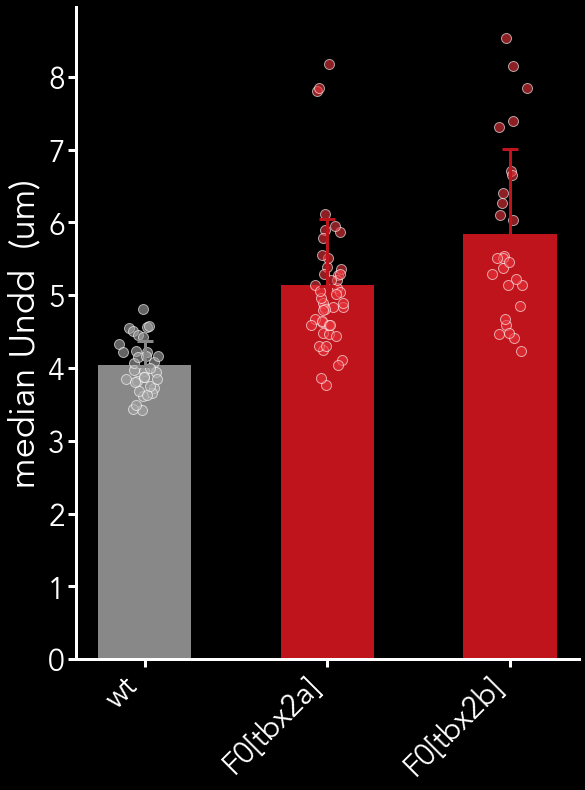

In [61]:

celltype = 'U'

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/wt/'
fPath = [
'20200821_5dpf_xOG_s1mCh_uninj_i05b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i05d/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06d/',
'20200821_5dpf_xOG_s1mCh_uninj_i101b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i101d/',
'20200821_5dpf_xOG_s1mCh_uninj_i102b/',
'20200821_5dpf_xOG_s1mCh_uninj_i103b/',
'20200821_5dpf_xOG_s1mCh_uninj_i104b/',
'20200821_5dpf_xOG_s1mCh_uninj_i104d/',
'20201113_5dpf_xOG_s1mCh_uninj_i06b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i12b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i12d/',
'20201113_5dpf_xOG_s1mCh_uninjected_i13b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i15b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i15d/',
'20210514_5dpf_xOG_s1C_uninj_L01b_withDAPI/',
'20210514_5dpf_xOG_s1C_uninj_L05b_withDAPI/',
'20210514_5dpf_xOG_s1C_uninj_L07b_withDAPI/',
'20221026_5dpf_xOG_s1C_wt_L01_002/',
'20221026_5dpf_xOG_s1C_wt_L01_004/',
'20221026_5dpf_xOG_s1C_wt_L02_002/',
'20221026_5dpf_xOG_s1C_wt_L03_002/',
'20221026_5dpf_xOG_s1C_wt_L03_004/',
'20221026_5dpf_xOG_s1C_wt_L04_002/',
'20221026_5dpf_xOG_s1C_wt_L04_004/',
'20221026_5dpf_xOG_s1C_wt_L05_002/',
'20221026_5dpf_xOG_s1C_wt_L05_004/',
'20221026_5dpf_xOG_s1C_wt_L06_002/',
'20221026_5dpf_xOG_s1C_wt_L07_002/',
'20221026_5dpf_xOG_s1C_wt_L07_004/',
'20221026_5dpf_xOG_s1C_wt_L08_002/',
'20221026_5dpf_xOG_s1C_wt_L08_004/',
'20221026_5dpf_xOG_s1C_wt_L09_002/',
'20221026_5dpf_xOG_s1C_wt_L09_004/',
'20221026_5dpf_xOG_s1C_wt_L10_002/',
'20221026_5dpf_xOG_s1C_wt_L10_004/',
'20221026_5dpf_xOG_s1C_wt_L11_002/',
'20221026_5dpf_xOG_s1C_wt_L12_002/',
]


nndUMean_wt = np.empty((len(fPath),1))
nndUMean_wt[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_wt[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;


dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2a/'
fPath = [
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i05b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i05d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i06b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i06d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i07b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i07d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i08b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i08d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i09b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i09d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i10b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i10d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i11b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i11d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L01b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L02b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L03b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L04b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L05b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L06b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L07b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L07d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L08b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L08d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L09b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L10b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L11b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L11d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L12b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L13b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L13d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L14b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L15b/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L02_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L03_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L05_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L08_004/',
]


nndUMean_tbx2a = np.empty((len(fPath),1))
nndUMean_tbx2a[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_tbx2a[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;

    
dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/'
fPath = [
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i09b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13d/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i14b/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L03_002/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L03_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L12_002/',
]    

nndUMean_tbx2b = np.empty((len(fPath),1))
nndUMean_tbx2b[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_tbx2b[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;



plotname = ''
fH, axH = plt.subplots(figsize= [9,12])

i = 0
for nndM,geneColor,geneMarker in zip([nndUMean_wt,nndUMean_tbx2a,nndUMean_tbx2b],['#888888','#BF141B','#BF141B'],['o','o','o']):
    i = i+1
    jitter = np.random.randn(len(nndM))*0.05
    pH = plt.bar(i, np.mean(nndM), width=0.5, color=geneColor, linewidth = 2, edgecolor = geneColor);
    pH = plt.errorbar(i, np.mean(nndM), yerr = [[0],[np.std(nndM)]], ecolor=geneColor, elinewidth=3, capsize=8, capthick=3, zorder=9)
    pH = plt.scatter(np.ones(len(nndM))*i+jitter, nndM,
             color=lighten_color(geneColor,.75), zorder=8, marker = geneMarker, s=100, edgecolor=baseColor, linewidth=1, alpha = 0.6);

fontLabels = formatFigureMain(fH, axH, pH)
axH.set_xticks([1,2,3]);
axH.set_xticklabels(['wt','F0[tbx2a]','F0[tbx2b]']);
axH.xaxis.set_tick_params(rotation=45)
# axH.set_ylim([0,300]); # tbx2
axH.set_ylabel('median {0}ndd  (um)'.format(celltype), fontproperties=fontLabels)
plt.show()


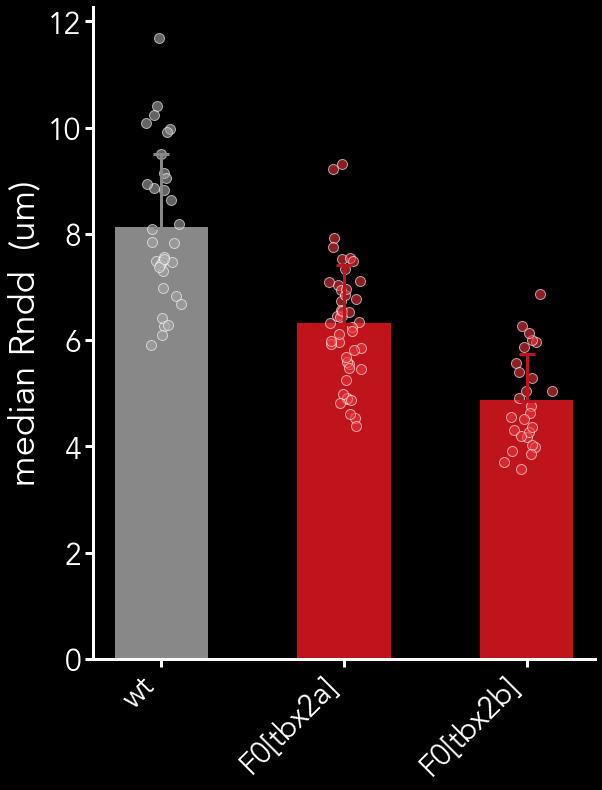

In [63]:

celltype = 'R'

dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/wt/'
fPath = [
'20200821_5dpf_xOG_s1mCh_uninj_i05b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i05d/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06d/',
'20200821_5dpf_xOG_s1mCh_uninj_i101b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i101d/',
'20200821_5dpf_xOG_s1mCh_uninj_i102b/',
'20200821_5dpf_xOG_s1mCh_uninj_i103b/',
'20200821_5dpf_xOG_s1mCh_uninj_i104b/',
'20200821_5dpf_xOG_s1mCh_uninj_i104d/',
'20201113_5dpf_xOG_s1mCh_uninj_i06b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i12b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i12d/',
'20201113_5dpf_xOG_s1mCh_uninjected_i13b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i15b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i15d/',
'20210514_5dpf_xOG_s1C_uninj_L01b_withDAPI/',
'20210514_5dpf_xOG_s1C_uninj_L05b_withDAPI/',
'20210514_5dpf_xOG_s1C_uninj_L07b_withDAPI/',
'20221026_5dpf_xOG_s1C_wt_L01_002/',
'20221026_5dpf_xOG_s1C_wt_L01_004/',
'20221026_5dpf_xOG_s1C_wt_L02_002/',
'20221026_5dpf_xOG_s1C_wt_L03_002/',
'20221026_5dpf_xOG_s1C_wt_L03_004/',
'20221026_5dpf_xOG_s1C_wt_L04_002/',
'20221026_5dpf_xOG_s1C_wt_L04_004/',
'20221026_5dpf_xOG_s1C_wt_L05_002/',
'20221026_5dpf_xOG_s1C_wt_L05_004/',
'20221026_5dpf_xOG_s1C_wt_L06_002/',
# '20221026_5dpf_xOG_s1C_wt_L07_002/',
'20221026_5dpf_xOG_s1C_wt_L07_004/',
'20221026_5dpf_xOG_s1C_wt_L08_002/',
'20221026_5dpf_xOG_s1C_wt_L08_004/',
'20221026_5dpf_xOG_s1C_wt_L09_002/',
'20221026_5dpf_xOG_s1C_wt_L09_004/',
'20221026_5dpf_xOG_s1C_wt_L10_002/',
'20221026_5dpf_xOG_s1C_wt_L10_004/',
'20221026_5dpf_xOG_s1C_wt_L11_002/',
'20221026_5dpf_xOG_s1C_wt_L12_002/',
]


nndUMean_wt = np.empty((len(fPath),1))
nndUMean_wt[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_wt[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;


dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2a/'
fPath = [
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i05b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i05d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i06b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i06d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i07b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i07d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i08b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i08d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i09b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i09d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i10b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i10d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i11b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i11d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L01b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L02b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L03b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L04b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L05b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L06b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L07b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L07d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L08b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L08d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L09b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L10b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L11b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L11d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L12b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L13b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L13d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L14b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L15b/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L02_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L03_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L05_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L08_004/',
]


nndUMean_tbx2a = np.empty((len(fPath),1))
nndUMean_tbx2a[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_tbx2a[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;

    
dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/'
fPath = [
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i09b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13d/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i14b/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L03_002/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L03_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L12_002/',
]    

nndUMean_tbx2b = np.empty((len(fPath),1))
nndUMean_tbx2b[:]=np.NaN
i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    nndUMean_tbx2b[i,0] = np.median(nnd) * 63.64/1024
    i=i+1;



plotname = ''
fH, axH = plt.subplots(figsize= [9,12])

i = 0
for nndM,geneColor,geneMarker in zip([nndUMean_wt,nndUMean_tbx2a,nndUMean_tbx2b],['#888888','#BF141B','#BF141B'],['o','o','o']):
    i = i+1
    jitter = np.random.randn(len(nndM))*0.05
    pH = plt.bar(i, np.mean(nndM), width=0.5, color=geneColor, linewidth = 2, edgecolor = geneColor);
    pH = plt.errorbar(i, np.mean(nndM), yerr = [[0],[np.std(nndM)]], ecolor=geneColor, elinewidth=3, capsize=8, capthick=3, zorder=9)
    pH = plt.scatter(np.ones(len(nndM))*i+jitter, nndM,
             color=lighten_color(geneColor,.75), zorder=8, marker = geneMarker, s=100, edgecolor=baseColor, linewidth=1, alpha = 0.6);

fontLabels = formatFigureMain(fH, axH, pH)
axH.set_xticks([1,2,3]);
axH.set_xticklabels(['wt','F0[tbx2a]','F0[tbx2b]']);
axH.xaxis.set_tick_params(rotation=45)
# axH.set_ylim([0,300]); # tbx2
axH.set_ylabel('median {0}ndd  (um)'.format(celltype), fontproperties=fontLabels)
plt.show()


#### Violin plots

TypeError: 'AxesSubplot' object is not subscriptable

Text(0, 0.5, 'Rndd  (um)')

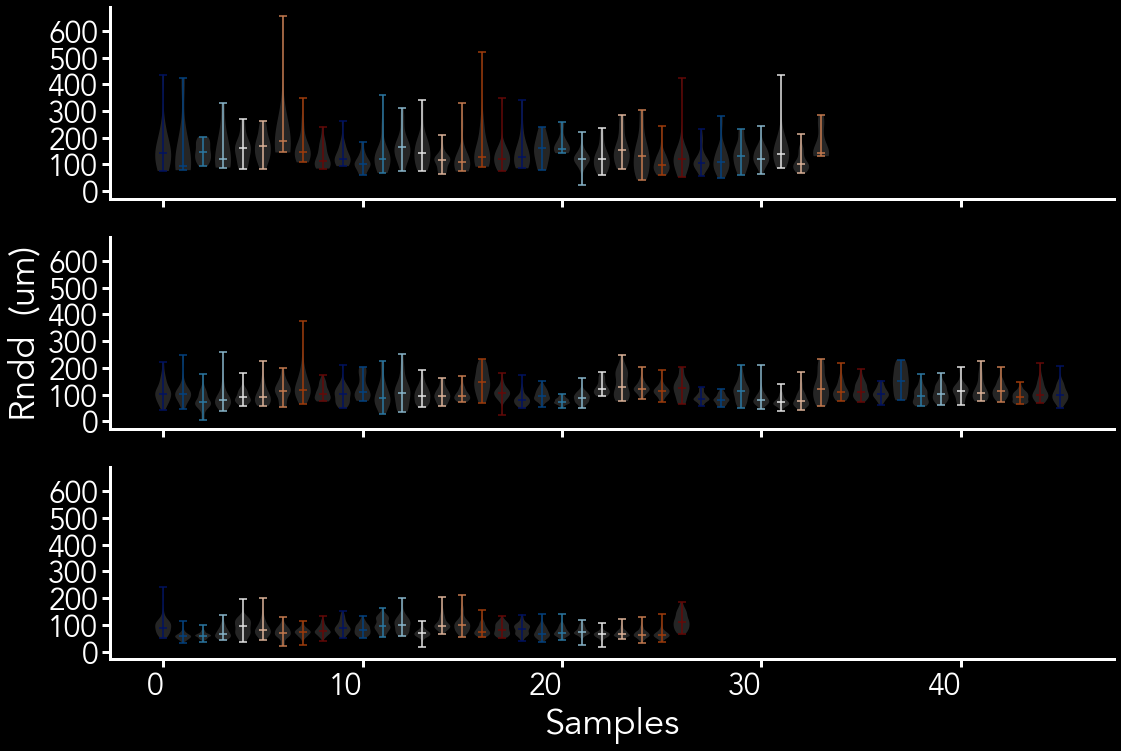

In [281]:
celltype = 'R'


plotname = ''
fH, axH = plt.subplots(3,1,figsize= [18,12], sharey=True, sharex = True)


dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/wt/'
fPath = [
'20200821_5dpf_xOG_s1mCh_uninj_i05b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i05d/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i06d/',
'20200821_5dpf_xOG_s1mCh_uninj_i101b/',
# '20200821_5dpf_xOG_s1mCh_uninj_i101d/',
'20200821_5dpf_xOG_s1mCh_uninj_i102b/',
'20200821_5dpf_xOG_s1mCh_uninj_i103b/',
'20200821_5dpf_xOG_s1mCh_uninj_i104b/',
'20200821_5dpf_xOG_s1mCh_uninj_i104d/',
'20201113_5dpf_xOG_s1mCh_uninj_i06b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i12b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i12d/',
'20201113_5dpf_xOG_s1mCh_uninjected_i13b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i15b/',
'20201113_5dpf_xOG_s1mCh_uninjected_i15d/',
'20210514_5dpf_xOG_s1C_uninj_L01b_withDAPI/',
'20210514_5dpf_xOG_s1C_uninj_L05b_withDAPI/',
'20210514_5dpf_xOG_s1C_uninj_L07b_withDAPI/',
'20221026_5dpf_xOG_s1C_wt_L01_002/',
'20221026_5dpf_xOG_s1C_wt_L01_004/',
'20221026_5dpf_xOG_s1C_wt_L02_002/',
'20221026_5dpf_xOG_s1C_wt_L03_002/',
'20221026_5dpf_xOG_s1C_wt_L03_004/',
'20221026_5dpf_xOG_s1C_wt_L04_002/',
'20221026_5dpf_xOG_s1C_wt_L04_004/',
'20221026_5dpf_xOG_s1C_wt_L05_002/',
'20221026_5dpf_xOG_s1C_wt_L05_004/',
'20221026_5dpf_xOG_s1C_wt_L06_002/',
# '20221026_5dpf_xOG_s1C_wt_L07_002/',
'20221026_5dpf_xOG_s1C_wt_L07_004/',
'20221026_5dpf_xOG_s1C_wt_L08_002/',
'20221026_5dpf_xOG_s1C_wt_L08_004/',
'20221026_5dpf_xOG_s1C_wt_L09_002/',
'20221026_5dpf_xOG_s1C_wt_L09_004/',
'20221026_5dpf_xOG_s1C_wt_L10_002/',
'20221026_5dpf_xOG_s1C_wt_L10_004/',
'20221026_5dpf_xOG_s1C_wt_L11_002/',
'20221026_5dpf_xOG_s1C_wt_L12_002/',
]


i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    vp = axH[0].violinplot(dataset=nnd,positions=[i], widths=.8, showextrema=True, showmedians=True)
    for body in vp['bodies']:
        body.set_facecolor(zfC[celltype])
    i=i+1;


dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2a/'
fPath = [
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i05b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i05d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i06b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i06d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i07b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i07d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i08b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i08d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i09b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i09d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i10b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i10d/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i11b/',
'20200821_5dpf_xOG_s1mCh_CRtbx2a_i11d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L01b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L02b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L03b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L04b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L05b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L06b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L07b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L07d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L08b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L08d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L09b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L10b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L11b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L11d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L12b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L13b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L13d/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L14b/',
'20210514_5dpf_xOG_s1C_CRtbx2a_L15b/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L02_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L03_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L05_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2aF0_L08_004/',
]


i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    vp = axH[1].violinplot(dataset=nnd,positions=[i], widths=.8, showextrema=True, showmedians=True)
    for body in vp['bodies']:
        body.set_facecolor(zfC[celltype])
    i=i+1;

    
dPath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Analysis/CRtbx2F0s/xOGs1C/tbx2b/'
fPath = [
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i09b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i10d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i12d/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13b/',
'20201113_5dpf_xOG_s1mCh_CRtbx2b_i13d/',
# '20201113_5dpf_xOG_s1mCh_CRtbx2b_i14b/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L01_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L02_004/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L03_002/',
# '20221026_5dpf_xOG_s1C_tbx2bF0_L03_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L04_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L05_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L06_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L07_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L08_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L09_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L10_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_002/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L11_004/',
'20221026_5dpf_xOG_s1C_tbx2bF0_L12_002/',
]    

i=0;
for filepath in fPath:
    nnd = np.load(dPath + filepath + celltype + '_nnd.npy')
    vp = axH[2].violinplot(dataset=nnd,positions=[i], widths=.8, showextrema=True, showmedians=True)
    for body in vp['bodies']:
        body.set_facecolor(zfC[celltype])
    i=i+1;


    
    
fontLabels = formatFigureMain(fH, axH[0], pH)
fontLabels = formatFigureMain(fH, axH[1], pH)
fontLabels = formatFigureMain(fH, axH[2], pH)
axH[2].set_xlabel('Samples', fontproperties=fontLabels)
axH[1].set_ylabel('{0}ndd  (um)'.format(celltype), fontproperties=fontLabels)

In [245]:

    
# vp[i] = axH[2].violinplot(dataset=nnd,positions=[i], widths=.8, showextrema=False, showmedians=True)

SyntaxError: invalid syntax (987083096.py, line 1)

IndexError: list index out of range

# NDD on other photoreceptors (from labels layers)

In [ ]:
dPath = '/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/CRnr2e3F0s/xOGaCT/wt/'
fPath = '20220121_5dpf_xOG_aCT_wt_L01_002/'
lPath = 'R_seg_curated.tiff'

labelData = imread(dPath + fPath + lPath)
# labelData

centroidData = calculateCentroidsFromLabels(labelData)
centroidData

In [ ]:
fH, axH = plt.subplots(figsize= [16,16])


pH = axH.imshow(labelData, cmap='bone')
pH = axH.scatter(centroidData[:,0],centroidData[:,1], color=zfC['R'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = 0.99);

## <a id='voronoi'>Voronoi</a>
Nice visualization, not extremely useful by itself


> [Back to index](#Index)

In [ ]:
np.size(vorU.regions[1])

In [ ]:
dPath = "/Users/angueyraaristjm/Documents/eelImaging/tempAnalysis/photoArrays/"
fUName = "U_missing.csv"
fNName = "N_points.csv"
nucsTiff = '20220121_5dpf_xOG_aCT_nr2e3_L06_004' + '.tiff'


Nucs = plt.imread(dPath + nucsName)

df =  pd.read_csv(dPath + fUName)
df = df.drop(columns = 'index')
U=df.to_numpy()
U = U[:,[1,0]]
vorU = scipy.spatial.Voronoi(U)

df =  pd.read_csv(dPath + fNName)
df = df.drop(columns = 'index')
N=df.to_numpy()
N = N[:,[1,0]]
vorN = scipy.spatial.Voronoi(N)

vorN = scipy.spatial.Voronoi(np.append(U,N,axis=0))

plotname = ''
fH, axH = plt.subplots(figsize= [16,16])

pH = axH.imshow(imread(dPath + nucsTiff), cmap='bone')


pH = plt.scatter(U[:,0],U[:,1], color=zfC['U'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .6);
pH = scipy.spatial.voronoi_plot_2d(vorU, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['U'], line_width=2, line_alpha=0.6, point_size=2)


regions, vertices = voronoi_finite_polygons_2d(vorU)
# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.1)
    
# pH = plt.scatter(N[:,0],N[:,1], color=zfC['actb2'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .6);
# pH = voronoi_plot_2d(vorN, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['actb2'], line_width=2, line_alpha=0.6, point_size=2)

formatFigureMain(fH, axH, pH);

axH.set_xlim([-100,1124])
axH.set_ylim([-100,1124])

def p2umfx(x, pos): # formatter function
    s = '{:.2f}'.format(np.round(x * p2um,decimals=2))
    return s

axH.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(p2umfx))
axH.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(p2umfx))

# savePath = '/Users/angueyraaristjm/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/zf/Manuscripts/2021_zfConeRNAseq/newGeneFigures/temp/'
# plt.savefig(savePath + goi + "_counts.svg", transparent=True, format="svg", bbox_inches = "tight")

### Lloyd's algorithm to make distribution more even
- Wikipedia: [Lloyd's algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm)
- Implementation: [github.com/duhaime/lloyd](https://github.com/duhaime/lloyd)
    - Modified to use image boundaries (plus buffer) as mask for voronoi polygons during Lloyd's relaxation
    - Could use voronoi polygons to shapes or labels layers in napari [linkhere](https://napari.org/stable/gallery/shapes_to_labels.html)
        - there will be problems with vertices at infinity [someInforHere](https://stackoverflow.com/questions/23901943/voronoi-compute-exact-boundaries-of-every-region)
    

In [ ]:
# field = Field(np.multiply(np.ones(np.shape(U)),512)+np.random.normal(size=np.shape(U))) # start near the center and expand
field = Field(U, buffer = 20) #start from original locations of UV cones

nIterations = 2
with tqdm(total=nIterations, file=sys.stdout) as progBar:
# run Lloyd relaxation on the field of points
    for i in np.arange(0,nIterations):
        field.relax()
        progBar.update(1)



# get the resulting point positions
Ui = field.get_points()

vorUi = scipy.spatial.Voronoi(Ui)

# boundedRegions,boundedVertices = voronoi_finite_polygons_2d(vorUi)
# vorUi.regions = boundedRegions
# vorUi.vertices = boundedVertices


plotname = ''
fH, axH = plt.subplots(figsize= [16,16])


pH = plt.scatter(U[:,0],U[:,1], color=zfC['U'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .2);
pH = scipy.spatial.voronoi_plot_2d(vorU, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['U'], line_width=2, line_alpha=0.2, point_size=2)

pH = plt.scatter(Ui[:,0],Ui[:,1], color=zfC['S'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .8);
pH = scipy.spatial.voronoi_plot_2d(vorUi, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['S'], line_width=2, line_alpha=0.8, point_size=2)


border = [[0,0],[0,1024],[1024,1024],[1024,0]]
plt.fill(*zip(*border),alpha=0.5,facecolor='None',edgecolor='r')


regions, vertices = voronoi_finite_polygons_2d(vorUi)
clip = PolygonClipper()
# colorize
for region in regions:
    polygon = vertices[region]
    clipped = clip(polygon,border)
    plt.fill(*zip(*clipped), alpha=0.5)





# pH = plt.scatter(N[:,0],N[:,1], color=zfC['actb2'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .6);
# pH = voronoi_plot_2d(vorN, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['actb2'], line_width=2, line_alpha=0.6, point_size=2)

formatFigureMain(fH, axH, pH);


axH.set_xlim([-1000,2124])
axH.set_ylim([-1000,2124])
    
    

In [ ]:
kdtUi = scipy.spatial.KDTree(Ui)
kN = 1
Uinnd = np.empty((len(Ui),kN))
Uinnd[:]=np.NaN



for n in range(0,len(Ui)):
    temp = kdtUi.query(Ui[n],kN+1)
    for k in range (0,kN):
        Uinnd[n,k] = temp[0][k+1]


plotname = ''
fH, axH = plt.subplots(figsize= [12,6])
    
for k in range (0,kN):
    pH = plt.hist(Unnd[:,k], bins=40, color=zfC['U'], zorder=8 , edgecolor=baseColor, linewidth=0.5, alpha = .8);
    pH = plt.hist(Uinnd[:,k], bins=40, color=zfC['S'], zorder=8 , edgecolor=baseColor, linewidth=0.5, alpha = .8);

axH.set_xlim([0,np.max((Unnd)*1.2)])

formatFigureMain(fH, axH, pH);
plt.show();

print ('\n')
for k in range (0,kN):
    print ('Median for {0}-NDD : {1:.2f} pixels'.format(k+1,np.median(Unnd[:,k])))
    print ('Median for {0}-NDD after Lloyd\'s relaxation : {1:.2f} pixels'.format(k+1,np.median(Uinnd[:,k])))

In [ ]:
U = nnd.Centroids
vorU = nnd.vor

#### Clipping polygon example

In [ ]:
plotname = ''
fH, axH = plt.subplots(figsize= [16,16])

# pH = axH.imshow(Nucs, cmap='bone')

pH = plt.scatter(U[:,0],U[:,1], color=zfC['U'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .2);
pH = scipy.spatial.voronoi_plot_2d(vorU, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['U'], line_width=2, line_alpha=0.8, point_size=2)

# pH = plt.scatter(Ui[:,0],Ui[:,1], color=zfC['S'], zorder=8, marker = 'o', s=50, edgecolor=baseColor, linewidth=0.5, alpha = .8);
# pH = scipy.spatial.voronoi_plot_2d(vorUi, ax = axH, show_points = False, show_vertices=False, line_colors=zfC['S'], line_width=2, line_alpha=0.8, point_size=2)

# polygon = vorUi.vertices[vorUi.regions[24]]
# polygon = field.voronoi.vertices[field.voronoi.regions[30]+field.voronoi.regions[0]]
polygon = field.voronoi.vertices[field.voronoi.regions[12]]
plt.fill(*zip(*polygon),alpha=0.5,facecolor='r',edgecolor='k')


border = field.get_bb_pointsClockwise()
# border = [[0,0],[0,1024],[1024,1024],[1024,0]]
plt.fill(*zip(*border),alpha=0.5,facecolor='None',edgecolor='r')

clip = PolygonClipper()
clipped = clip(polygon,border)

plt.fill(*zip(*clipped),alpha=0.5,facecolor='g')

axH.set_xlim([-200,1200])
axH.set_ylim([-200,1200])